In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import KMeansSMOTE, SMOTE
from category_encoders import TargetEncoder, OneHotEncoder as OHE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC


from tqdm.notebook import tqdm


import time


from warnings import filterwarnings

from IPython.display import display, Markdown, Latex

filterwarnings('ignore')

In [2]:
dftrain = pd.read_csv('./data/train.csv',index_col=0)

In [3]:
dftest = pd.read_csv('./data/test_x.csv',index_col=0)

In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7001 entries, 0 to 7000
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Hour               7001 non-null   int64  
 1   Minutes            7001 non-null   int64  
 2   Sensor_alpha       7001 non-null   float64
 3   Sensor_beta        7001 non-null   float64
 4   Sensor_gamma       7001 non-null   float64
 5   Sensor_alpha_plus  7001 non-null   float64
 6   Sensor_beta_plus   7001 non-null   float64
 7   Sensor_gamma_plus  7001 non-null   float64
 8   Insect             7001 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 547.0 KB


In [5]:
dftrain.describe()

,Hour,Minutes,Sensor_alpha,Sensor_beta,Sensor_gamma,Sensor_alpha_plus,Sensor_beta_plus,Sensor_gamma_plus,Insect
count,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000
mean,19.598914,29.405942,0.477171,-29.974117,-5.624690,7.188060,-0.757901,-0.554533,0.595772
std,3.507008,17.375830,99.294856,133.095125,115.871391,122.327980,100.039477,100.535951,0.661604
min,1.000000,0.000000,-404.898823,-656.272666,-448.478039,-437.205393,-387.567443,-374.961689,0.000000
25%,19.000000,14.000000,-68.573905,-116.060383,-83.508747,-79.496687,-68.061596,-69.652647,0.000000
50%,21.000000,29.000000,-0.287447,-36.171567,-1.217606,-1.133567,-0.444124,0.027128,0.000000
75%,21.000000,44.000000,66.480795,56.637778,76.870277,93.285286,66.181909,67.838524,1.000000
max,23.000000,59.000000,351.256221,518.395878,378.349287,462.556319,345.279240,363.682391,2.000000


Is data imbalanced?

In [6]:
dftrain.Insect.value_counts()

0    3519
1    2793
2     689
Name: Insect, dtype: int64

Yes, we check the relation between the majority and minority classes

In [7]:
3519/689

5.1074020319303335

#### Observing the data

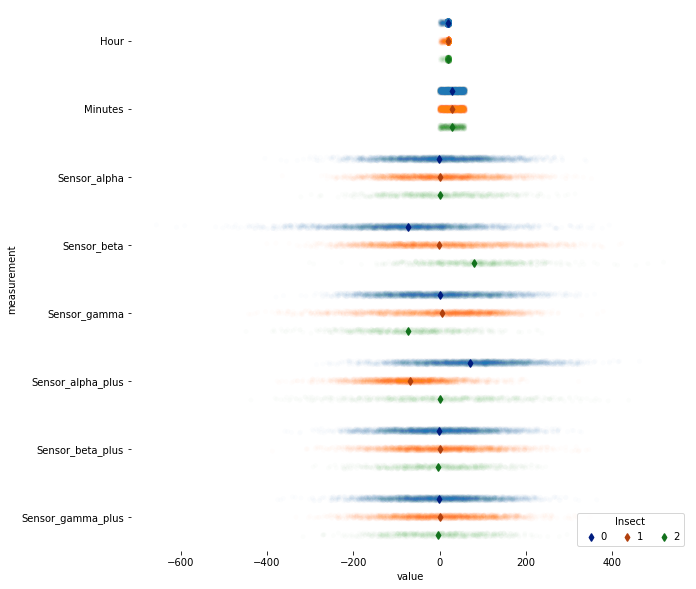

In [8]:
train = pd.melt(dftrain, 'Insect', var_name='measurement')

f, ax = plt.subplots(figsize=(10,10))
sns.despine(bottom=True, left=True)

sns.stripplot(x="value", y='measurement', hue='Insect',
             data=train, dodge=True, alpha=.01, zorder=1, palette='tab10')

sns.pointplot(x="value", y="measurement", hue="Insect",
              data=train, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="Insect",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)

In [9]:
train_cols = [col for col in dftest.columns]
target = 'Insect'
train_cols

['Hour',
 'Minutes',
 'Sensor_alpha',
 'Sensor_beta',
 'Sensor_gamma',
 'Sensor_alpha_plus',
 'Sensor_beta_plus',
 'Sensor_gamma_plus']

<AxesSubplot:>

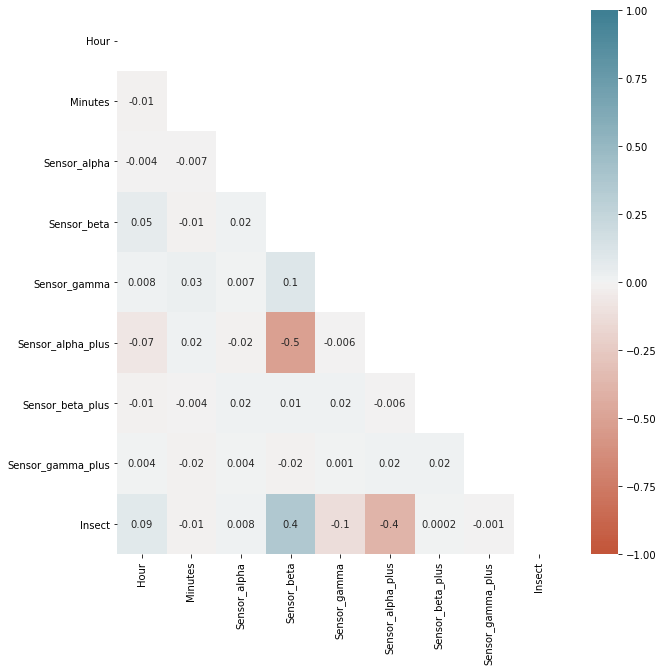

In [10]:
plt.figure(figsize=(10,10))

corr = dftrain.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, 
            cmap=sns.diverging_palette(20, 220, n=200), 
            vmin=-1., center=0, vmax=1, annot=True, fmt='.1g')

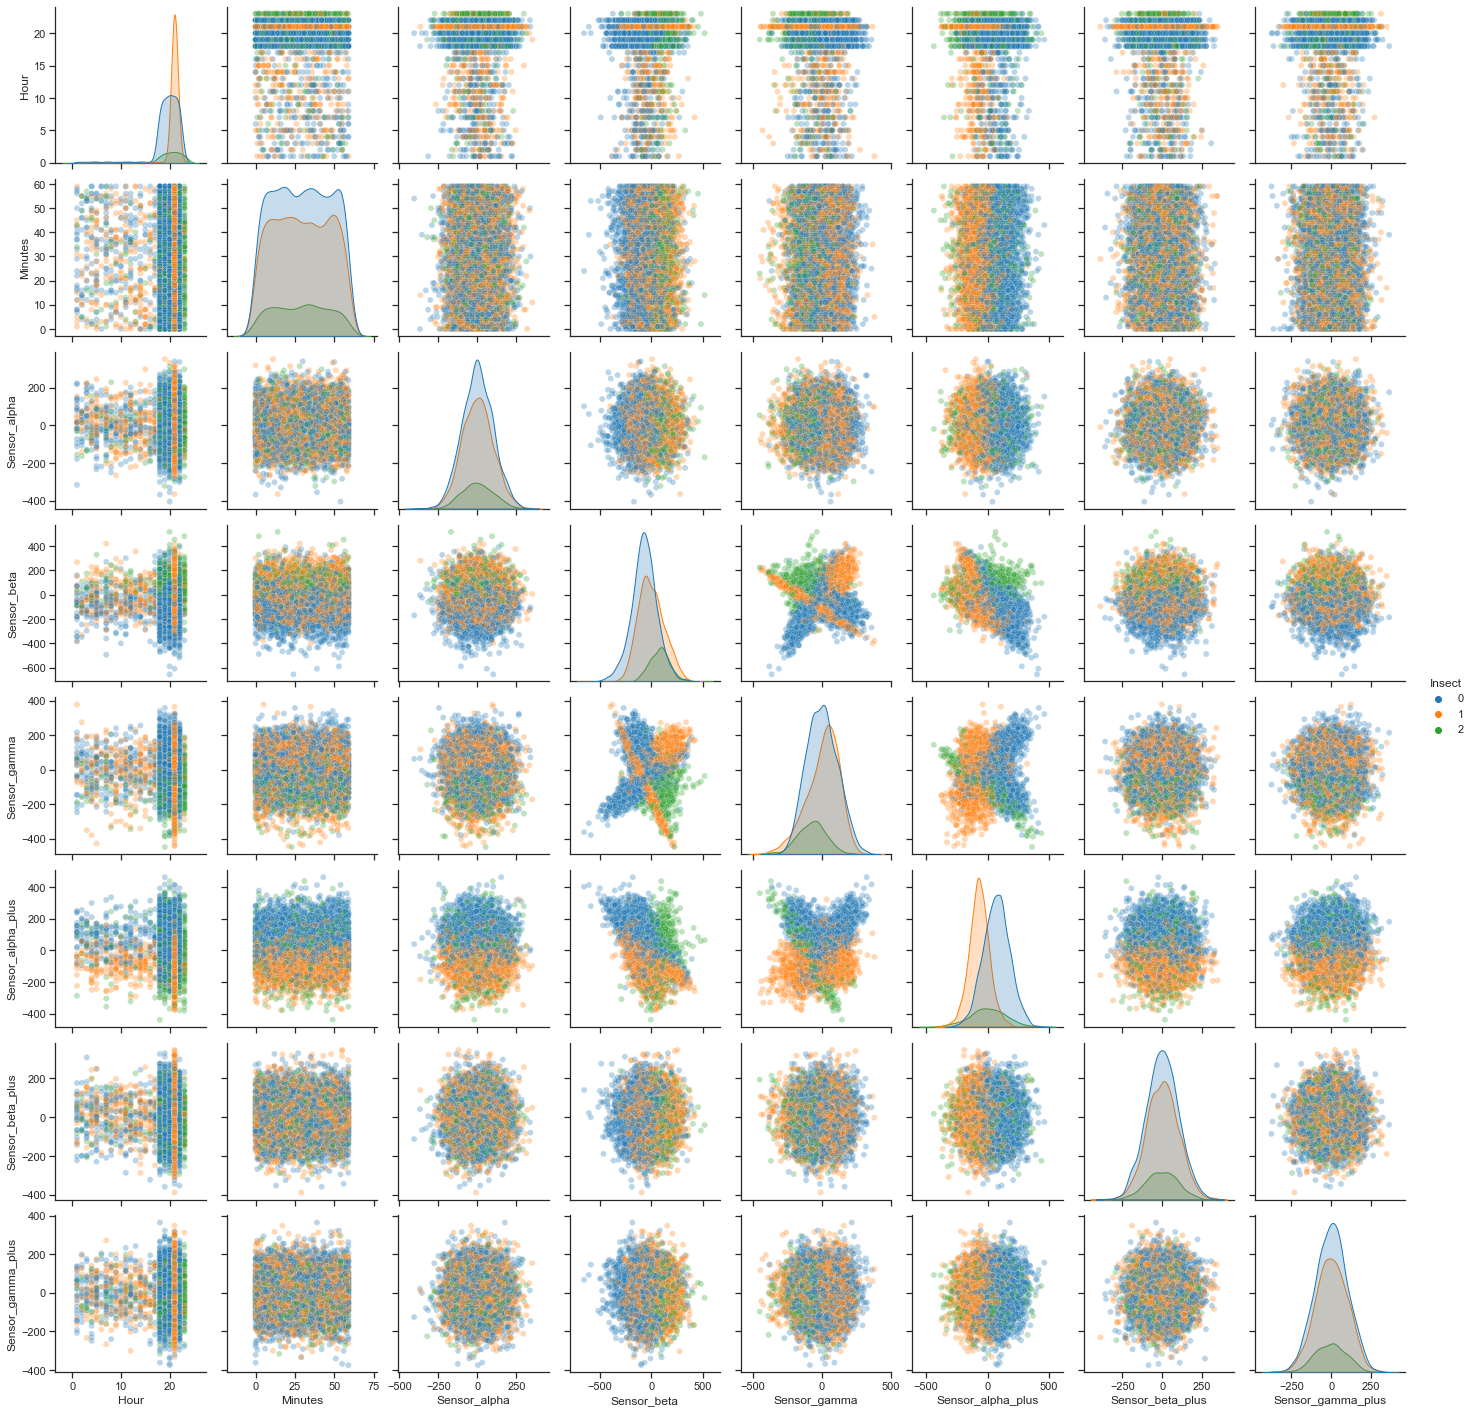

In [11]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(dftrain, hue="Insect", palette='tab10', plot_kws={'alpha':0.3})

### Model

In [12]:
SEED = 42
TEST_SIZE = 0.2
TESTING = True
FOLDS = 5

In [15]:
def run_experiment(train, test=None, model=None):
    if test is None:
        X_train, X_test, y_train, y_test = train_test_split(*train,  
                                                        test_size=TEST_SIZE, random_state=SEED)
    else:
        X_train, y_train = train
        X_test, y_test = test
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return f1_score(y_test, y_pred, average='macro'), model
  

#### Feature Engineering and Preprocessing

In [16]:
train_cols

['Hour',
 'Minutes',
 'Sensor_alpha',
 'Sensor_beta',
 'Sensor_gamma',
 'Sensor_alpha_plus',
 'Sensor_beta_plus',
 'Sensor_gamma_plus']

In [17]:
xg_params = {'objective':'multi:softmax',  
            'learning_rate' :0.1,
             'n_estimators':1500,
             'max_depth':7,
             'min_child_weight':1,
             'gamma':0,
             'subsample':0.8,
             'colsample_bytree':0.8,
             'nthread':4,
             'scale_pos_weight':5.1,                     
             'seed':42,
             'eval_metric':'merror'}

In [18]:
clf = XGBClassifier(**xg_params)

score, model = run_experiment((dftrain[train_cols],dftrain.Insect), model=clf)

[23:57:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [19]:
score

0.8540040231866698

In [20]:
np.unique(model.predict(dftest),return_counts=True)

(array([0, 1, 2]), array([1520, 1284,  196]))

In [21]:
preds = model.predict(dftest)

In [22]:
pd.DataFrame(preds, index=dftest.index).to_csv('results.csv')

#### CV

In [ ]:

dftrain['fold'] = -1

skf = StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(skf.split(dftrain[train_cols], dftrain[target])):
    print(fold, train_idx.shape, val_idx.shape)
    dftrain.loc[val_idx, 'fold'] = fold

In [ ]:
preds_oof = []
final_val_preds = {}

for fold in range(FOLDS):
    xtrain = dftrain[dftrain.fold != fold]
    xval = dftrain[dftrain.fold == fold]
    xtest= dftest
    
    valid_ids = xval.index.to_list()
    
    ytrain = xtrain[target]
    yval = xval[target]
       
    xtrain = xtrain[train_cols]
    xval = xval[train_cols]
    xtest = xtest[train_cols]
    
    model = XGBClassifier( **xg_params)
#     model = CatBoostClassifier(class_weights=[0.1, 0.9])
        
    ct = ColumnTransformer(
             transformers=[('num', RobustScaler(), train_cols)
                          ])
    
    xtrain_tr = ct.fit_transform(xtrain)
    xval_tr = ct.transform(xval)
    xtest_tr = ct.transform(xtest)
    
    model.fit(xtrain_tr, ytrain, eval_set=[(xtrain_tr,ytrain),(xval_tr,yval)], verbose=0 )
    
    preds_valid = model.predict_proba(xval_tr)
    preds_oof.append(model.predict_proba(xtest_tr)[:,1])
    final_val_preds.update(dict(zip(valid_ids, preds_valid)))
    f1 = f1_score(yval, model.predict(xval_tr), average='macro')
    f1tr = f1_score(ytrain, model.predict(xtrain_tr), average='macro')
    print(f'Fold {fold}\t val f1: {f1:.5f}, train f1: {f1tr:.5f} ')
    